In [254]:
# from flask import Flask, render_template, request, send_file
from PIL import Image, ImageDraw, ImageOps
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import random
# import warnings
# warnings.filterwarnings("ignore")

In [255]:
n_points = 300

In [256]:
image_path = "./images/obama.png" # Change to Relative Path or some hardcoded path on the repo

In [257]:
image = Image.open(image_path)
size = min(image.size)
image = ImageOps.fit(image, (size, size), Image.ANTIALIAS)
width, height = image.size

# Create a circular mask
mask = Image.new('L', image.size, 0)
draw = ImageDraw.Draw(mask)
draw.ellipse((0, 0, size, size), fill=255)

# Apply circular mask to the image
circular_image = Image.new('RGB', (width, height))
circular_image.paste(image, mask=mask)

# Save or serve the resulting image
output = BytesIO()
output_path = "./out_images/"+ image_path[9:]
circular_image.save(output, format='PNG')
circular_image.save(output_path, format='PNG')

In [258]:
def image_cleanup(img):
    # Maybe Do: Make the contrast more contrasty
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # blurred_image = cv2.GaussianBlur(gray_img, (5, 5), 0)

    # Scale the image to 400x400 pixels
    scaled_image = cv2.resize(gray_img, (400, 400))
    #reversed_image = cv2.bitwise_not(scaled_image)
    contrast = 1.5 # Contrast control ( 0 to 127)
    brightness = 1.
    
    out = cv2.addWeighted(scaled_image, contrast, scaled_image, 0, brightness)
    return out

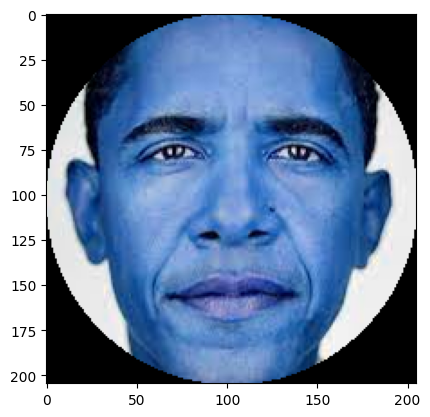

In [259]:
img = cv2.imread(output_path)
plt.imshow(img)

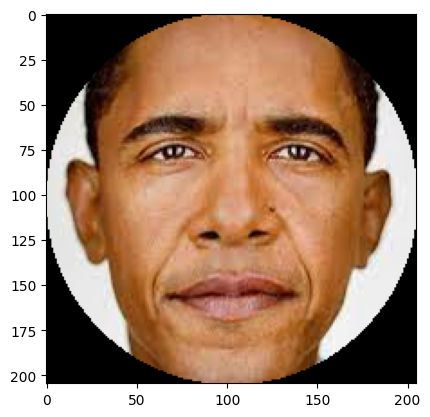

In [260]:
img2 = img[:,:,::-1]
plt.imshow(img2)

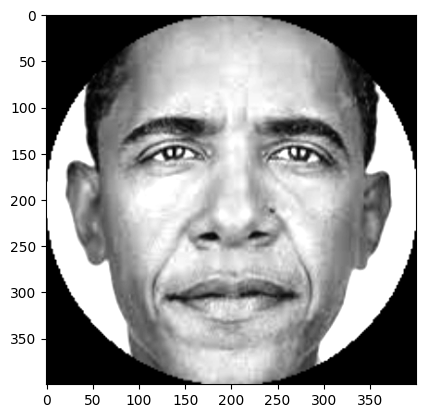

In [261]:
img3 = image_cleanup(img2)
plt.imshow(img3,'gray')

In [262]:
def edge_points(img, n):
    points = []
    height, width = img.shape
    # Define circle parameters (adjust these based on your image size)
    center_x = width // 2
    center_y = height // 2
    radius = min(center_x, center_y) - 1  # Ensure the circle is within the image bounds

    # Sample points along the circumference
    theta = np.linspace(0, 2 * np.pi, n)
    edge_points_x = np.uint16(center_x + radius * np.cos(theta))
    edge_points_y = np.uint16(center_y + radius * np.sin(theta))
    edge_points_x = edge_points_x.astype(np.int64)
    edge_points_y = edge_points_y.astype(np.int64)
    return edge_points_x, edge_points_y

def draw_lines(edge_x, edge_y):
    for i in range(0,n_points):
        for j in range(i,n_points):
            xs = [edge_x[i],edge_x[j]]
            ys = [edge_y[i],edge_y[j]]
            plt.plot(xs, ys,color='black',lw = 0.1)

edge_x, edge_y = edge_points(img3, n_points)
# plt.figure(figsize=(5,5))
# plt.plot(edge_x, edge_y,'o')
# draw_lines(edge_x, edge_y)

In [263]:
def bresenham(x1, y1, x2, y2, swap=False, neg_y=False):
    if y2 < y1 and not neg_y:
        return bresenham(x1, y1, x2, y2, swap=swap, neg_y=True)
    if x2 < x1:
        return bresenham(x2, y2, x1, y1, swap=swap)[::-1]
    line = []
    x = x1
    y = y1
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    if dy > dx:
        return bresenham(y1, x1, y2, x2, swap=True)
    P = 2 * dy - dx
    while x <= x2:
        if swap:
            line.append((y, x))
        else:
            line.append((x, y))
        x += 1
        if P < 0:
            P = P + 2 * dy
        else:
            P = P + 2 * dy - 2 * dx
            if neg_y:
                y -= 1
            else:
                y += 1
    return line

# bresenham(29,97,196,1)

In [264]:
def create_database(edge_x,edge_y):
    line_dict = dict()
    for i in range(0,n_points): # for every edge point
        for j in range(i+1,n_points): # go to all the others,  
            # Calculate intermediate points with bresenham
            points = [(edge_x[i],edge_y[i]), (edge_x[j],edge_y[j])]  
            # points.sort(key=lambda x: x[0]) # NOTE: Do we really need to sort?
            x1, y1 = points[0][0], points[0][1]
            x2, y2 = points[1][0], points[1][1]
            if not f"{x1},{y1}" in line_dict: line_dict[f"{x1},{y1}"] = dict()
            if not f"{x2},{y2}" in line_dict: line_dict[f"{x2},{y2}"] = dict()
            
            tmp = bresenham(x1,y1,x2,y2)
            line_dict[f"{x1},{y1}"][f"{x2},{y2}"] = tmp
            line_dict[f"{x2},{y2}"][f"{x1},{y1}"] = tmp
            # line_dict[f"{x1},{y1} {x2},{y2}"] = bresenham(x1,y1,x2,y2) # Add to dictionary
    return line_dict

line_dict = create_database(edge_x,edge_y)
# line_dict

In [265]:
def error(img,canvas,change):
    return np.sum(np.sum(abs(img-canvas))) - change

def try_line(points,current_canvas,img):
    lightness = 51
    change = 0
    change_weight = 0.02
    temp_canvas = np.copy(current_canvas) # NOTE: Find better approach than copying

    for x,y in points:
        # NOTE: Would be nice if SIMD can be incorporated somehow
        mask = (255-(temp_canvas[x,y] + lightness))>>31
        temp_canvas[x,y] = ((~mask&0xFF) & (lightness + temp_canvas[x,y])) | (mask & 0xFF) 
        change += ((~mask&0xFF) & (lightness)) | (mask & 0xFF) # NOTE: Needs rechecking

        # if (255 - temp_canvas[x,y]) < lightness:
        #     temp_canvas[x,y] += 255 - temp_canvas[x,y]
        #     change += 255 - temp_canvas[x,y]
        # else:
        #     temp_canvas[x,y] += lightness
        #     change += lightness
    return error(img,temp_canvas,change*change_weight), temp_canvas

In [266]:
def pick_next_point(start,current_canvas, img, line_dict):
    #filtered_dict = {key:value for key, value in line_dict.items() if start in key}
    #best_line = random.choice(list(filtered_dict.keys())) # initialise to random edge point
    # start_point = line_dict[start]
    best_line = random.choice(list(line_dict[start].keys())) # Initialize to random edge point
    best_error = try_line(line_dict[start][best_line],current_canvas,img)[0]
    # new_canvas = current_canvas.copy()
    new_canvas = current_canvas
    
    for key, value in line_dict[start].items():
        current_error, temp_canvas = try_line(line_dict[start][key], current_canvas,img)
        if current_error < best_error:
            best_error = current_error
            best_line = key
            new_canvas = temp_canvas
    # for end_point in best_line.split():
    #     if end_point != start:
    #         point = end_point
        point = best_line
    return point, new_canvas

In [267]:
def sim(n, img):
    start = '398,204'
    xs = [398]
    ys = [204]
    current_canvas = np.zeros_like(img)
    for i in range(n):
        # start_time = time.time() # PERF CHECK
        point, new_canvas = pick_next_point(start, current_canvas, img, line_dict)
        start = point
        x, y = point.split(',')
        xs.append(int(x))
        ys.append(int(y))
        current_canvas = new_canvas
        # print("--- %s seconds ---" % (time.time() - start_time)) # PERF CHECK

    return current_canvas, xs,ys

In [268]:
image = np.array(np.array(img3).tolist())
finished_canvas, xs,ys = sim(2000, image)
#plt.figure(figsize=(7,7))
# edge_x, edge_y = edge_points(img3, 100)
# plt.plot(edge_x, edge_y,'.',alpha = 0.2)
# plt.plot(xs,ys,alpha = 0.5,color='black')

--- 0.08808779716491699 seconds ---
--- 0.08652138710021973 seconds ---
--- 0.08649563789367676 seconds ---
--- 0.08651852607727051 seconds ---
--- 0.08851981163024902 seconds ---
--- 0.08751869201660156 seconds ---
--- 0.08751988410949707 seconds ---
--- 0.08552169799804688 seconds ---
--- 0.0860135555267334 seconds ---
--- 0.08752250671386719 seconds ---
--- 0.0865182876586914 seconds ---
--- 0.08716201782226562 seconds ---
--- 0.0894460678100586 seconds ---
--- 0.08751869201660156 seconds ---
--- 0.08651924133300781 seconds ---
--- 0.08798742294311523 seconds ---
--- 0.08798575401306152 seconds ---
--- 0.08651566505432129 seconds ---
--- 0.08751893043518066 seconds ---
--- 0.08608531951904297 seconds ---
--- 0.08651995658874512 seconds ---
--- 0.08651852607727051 seconds ---
--- 0.08851981163024902 seconds ---
--- 0.08601689338684082 seconds ---
--- 0.08750295639038086 seconds ---
--- 0.08649015426635742 seconds ---
--- 0.08451080322265625 seconds ---
--- 0.08551883697509766 seconds

In [269]:
# print(list(zip(xs,ys)))

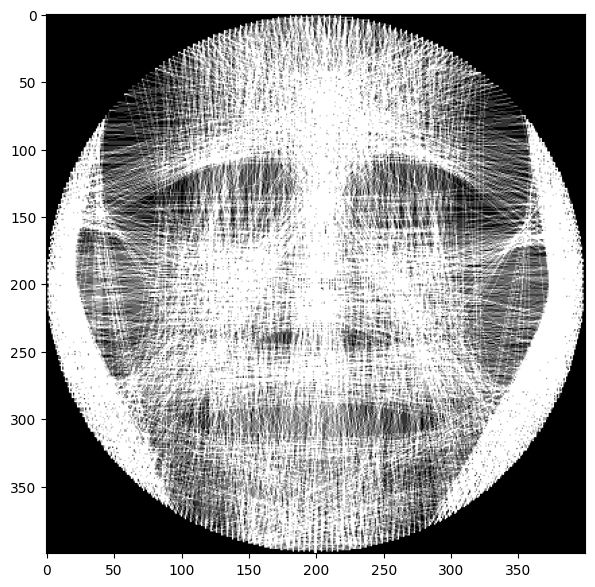

In [270]:
plt.figure(figsize=(7,7))
plt.imshow(finished_canvas, 'gray')
# plt.plot(xs,ys,'black', lw = 0.2)
# plt.imshow(img3)

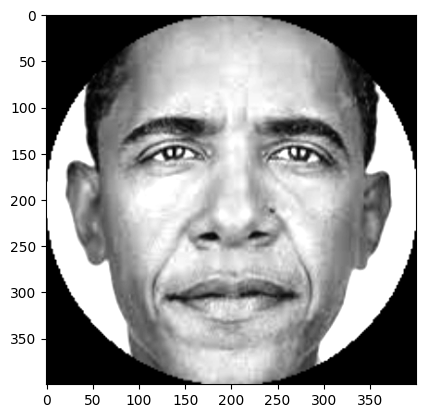

In [271]:
plt.imshow(image, 'gray')